In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter("ignore")

plt.style.use('bmh')

In [68]:
miguel = pd.read_csv("miguel_pm10_clean.csv",index_col=[1])
cuauh = pd.read_csv("cuauh_pm10_clean.csv",index_col=[1])
benito = pd.read_csv("benito_pm10_clean.csv",index_col=[1])

miguel.drop("Unnamed: 0",axis=1,inplace=True)
cuauh.drop("Unnamed: 0",axis=1,inplace=True)
benito.drop("Unnamed: 0",axis=1,inplace=True)

In [69]:
miguel_modelo= miguel.drop(["FECHA","HORA","AÑO","MES"],axis=1)
cuauh_modelo= cuauh.drop(["FECHA","HORA","AÑO","MES"],axis=1)
split_date='2018-01-01'

train1=miguel_modelo[miguel_modelo.index<=split_date].copy()
test1=miguel_modelo[miguel_modelo.index>split_date].copy()

train2=cuauh_modelo[cuauh_modelo.index<=split_date].copy()
test2=cuauh_modelo[cuauh_modelo.index>split_date].copy()

In [70]:
train1=train1.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})
test1=test1.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})

train2=train2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
test2=test2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train1.ds=pd.to_datetime(train1.ds)
train2.ds=pd.to_datetime(train2.ds)
test1.ds=pd.to_datetime(test1.ds)
test2.ds=pd.to_datetime(test2.ds)

train2.head()

,ds,y
0,2012-03-01 01:00:00,53.0
1,2012-03-01 02:00:00,46.0
2,2012-03-01 03:00:00,64.0
3,2012-03-01 04:00:00,61.0
4,2012-03-01 05:00:00,68.0


In [6]:
# modelo=Prophet(n_changepoints=15,
#                changepoint_prior_scale=0.65,
#                seasonality_prior_scale = 15,
#                #mcmc_samples=1000
#               ).fit(train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [9]:
def mape(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def smape(y_true,y_pred):
    return ((y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).mean() * 200

## El mejor hasta ahora

In [73]:
modelo1=Prophet(n_changepoints=15,
               changepoint_prior_scale=0.65,
                mcmc_samples=250,
                max_treedepth = 20
               #seasonality_prior_scale = 15,
               #interval_width=0.85,
              ).fit(train1)
pred1=modelo1.predict(test1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [74]:
mape(test1.y, pred1.yhat), smape(test1.y, pred1.yhat)

(73.17291948016901, 107.47432991651962)

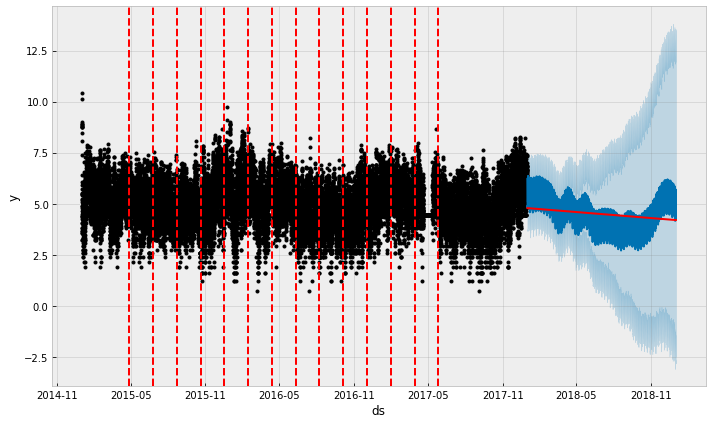

In [67]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo A
fig = modelo1.plot(pred1)
a = add_changepoints_to_plot(fig.gca(), modelo1, pred1)

In [19]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(modelo1, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-12-31 23:00:00 and 2016-12-31 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-01 00:00:00,20.958981,0.545751,41.411251,33.0,2016-12-31 23:00:00
1,2017-01-01 01:00:00,19.877571,-2.816205,40.333504,43.0,2016-12-31 23:00:00
2,2017-01-01 02:00:00,19.078451,-2.274989,39.182044,35.0,2016-12-31 23:00:00
3,2017-01-01 03:00:00,18.881505,-3.445185,40.968569,57.0,2016-12-31 23:00:00
4,2017-01-01 04:00:00,19.545809,-2.177273,40.392814,87.0,2016-12-31 23:00:00


In [25]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-01 00:00:00,20.958981,0.545751,41.411251,33.0,2016-12-31 23:00:00
1,2017-01-01 01:00:00,19.877571,-2.816205,40.333504,43.0,2016-12-31 23:00:00
2,2017-01-01 02:00:00,19.078451,-2.274989,39.182044,35.0,2016-12-31 23:00:00
3,2017-01-01 03:00:00,18.881505,-3.445185,40.968569,57.0,2016-12-31 23:00:00
4,2017-01-01 04:00:00,19.545809,-2.177273,40.392814,87.0,2016-12-31 23:00:00


In [22]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,36 days 12:00:00,529.020487,23.000445,18.652873,0.492095,0.613014
1,36 days 13:00:00,530.679029,23.036472,18.684759,0.492539,0.611872
2,36 days 14:00:00,532.804648,23.082562,18.714250,0.493256,0.611872
3,36 days 15:00:00,535.303163,23.136620,18.752488,0.494183,0.610731
4,36 days 16:00:00,535.981906,23.151283,18.760630,0.494680,0.610731
5,36 days 17:00:00,533.959144,23.107556,18.743796,0.495675,0.610731
6,36 days 18:00:00,531.133128,23.046326,18.722900,0.497451,0.610731
7,36 days 19:00:00,528.357863,22.986036,18.700165,0.498478,0.610731
8,36 days 20:00:00,526.544793,22.946564,18.683304,0.499251,0.610731
9,36 days 21:00:00,526.221730,22.939523,18.678765,0.499491,0.610731


In [ ]:
df_p.head()

### Cuahtemoc

In [75]:
modelo2=Prophet(n_changepoints=15,
               changepoint_prior_scale=0.5,
               #seasonality_prior_scale = 15,
               #interval_width=0.85,
              ).fit(train2)
pred2=modelo2.predict(test2)
mape(test2.y, pred2.yhat)

68.39962537049924

In [76]:
smape(test2.y, pred2.yhat)

42.251976305226414

### Usando Inverse Box-Cox Transform

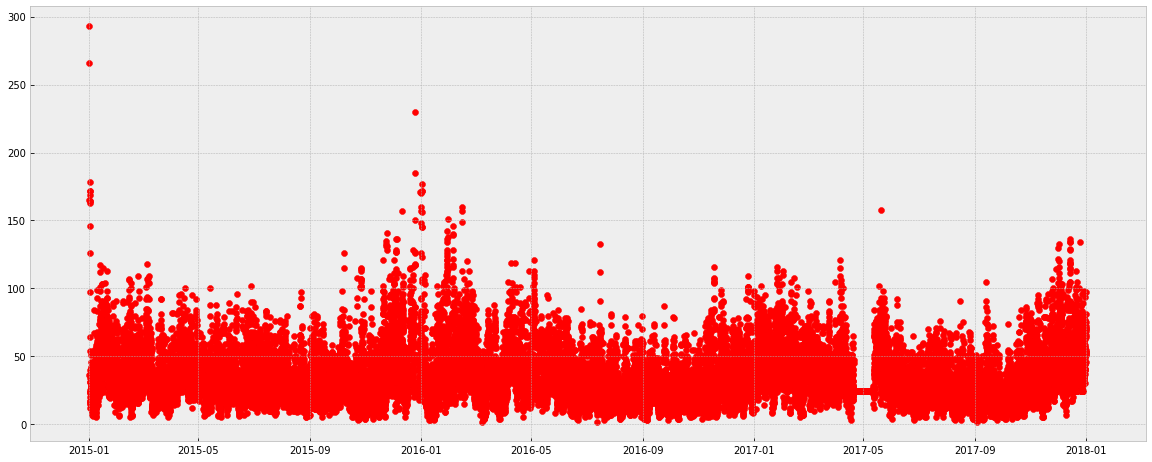

In [26]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(train1.ds, train1.y, color='r');

In [27]:
from scipy.stats import boxcox
train1.y, lam = boxcox(train1.y)

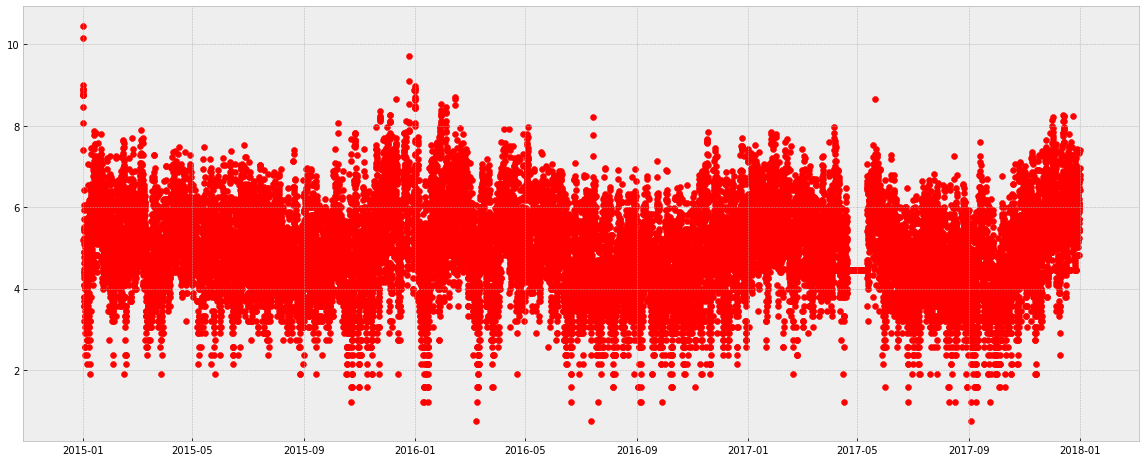

In [28]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(train1.ds, train1.y, color='r');

In [29]:
modelo1=Prophet(n_changepoints=15,
               changepoint_prior_scale=0.65,
               #seasonality_prior_scale = 15,
               #interval_width=0.85,
              ).fit(train1)

In [ ]:
mape(test1.y, pred1.yhat), smape(test1.y, pred1.yhat)

In [57]:
future = modelo1.make_future_dataframe(freq='H',periods=5000)

In [58]:
forecast = modelo1.predict(future)

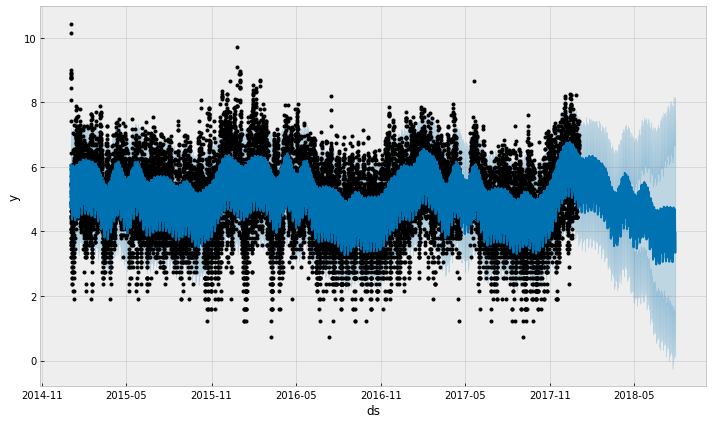

In [59]:
modelo1.plot(forecast);

In [60]:
from scipy.special import inv_boxcox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

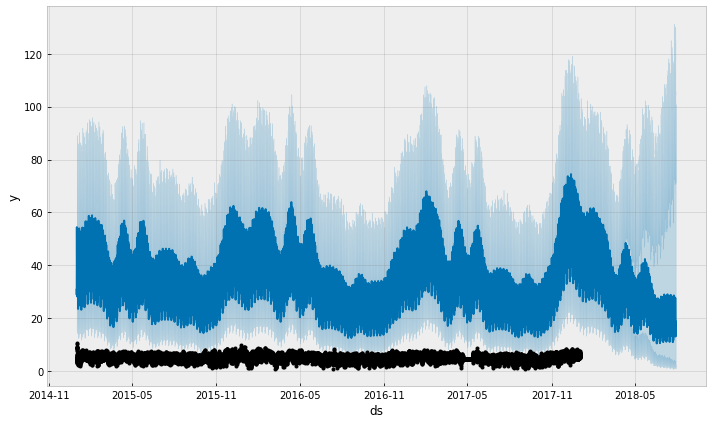

In [61]:
modelo1.plot(forecast);